In [ ]:
# ML-1 Временные ряды
# Преподаватель: Алексей Кузьмин
#
# Скачайте материалы к ДЗ из личного кабинета. ПРоанализируйте ряды, сделайте их стационарными.
# Решением будет ссылка на гитхаб с ноутбуком.




In [ ]:
# Базовое решение готово, но хочется поработать еще над стационарностью. Если можно, то прошу подождать с проверкой. 

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox

import time

%matplotlib inline

In [61]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 12), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return    

In [159]:
registration= pd.read_csv("monthly-us-auto-registration-tho.csv", sep=";")
dowjones = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

## Разбор ряда   monthly_us_auto_registration_tho

In [63]:
registration.head()


,Month,registration
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [64]:
first_year = (time.strptime(registration.iloc[0]['Month'], "%Y-%m").tm_year)

In [79]:
registration['time'] = registration.apply(lambda x: (time.strptime(x['Month'], "%Y-%m").tm_year-first_year)*12 + time.strptime(x['Month'], "%Y-%m").tm_mon -1, axis=1)

time_lags = registration['time']
registration_raw = registration['registration']


registration.head()

,Month,registration,time
0,1947-01,209,0
1,1947-02,214,1
2,1947-03,265,2
3,1947-04,290,3
4,1947-05,287,4


Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


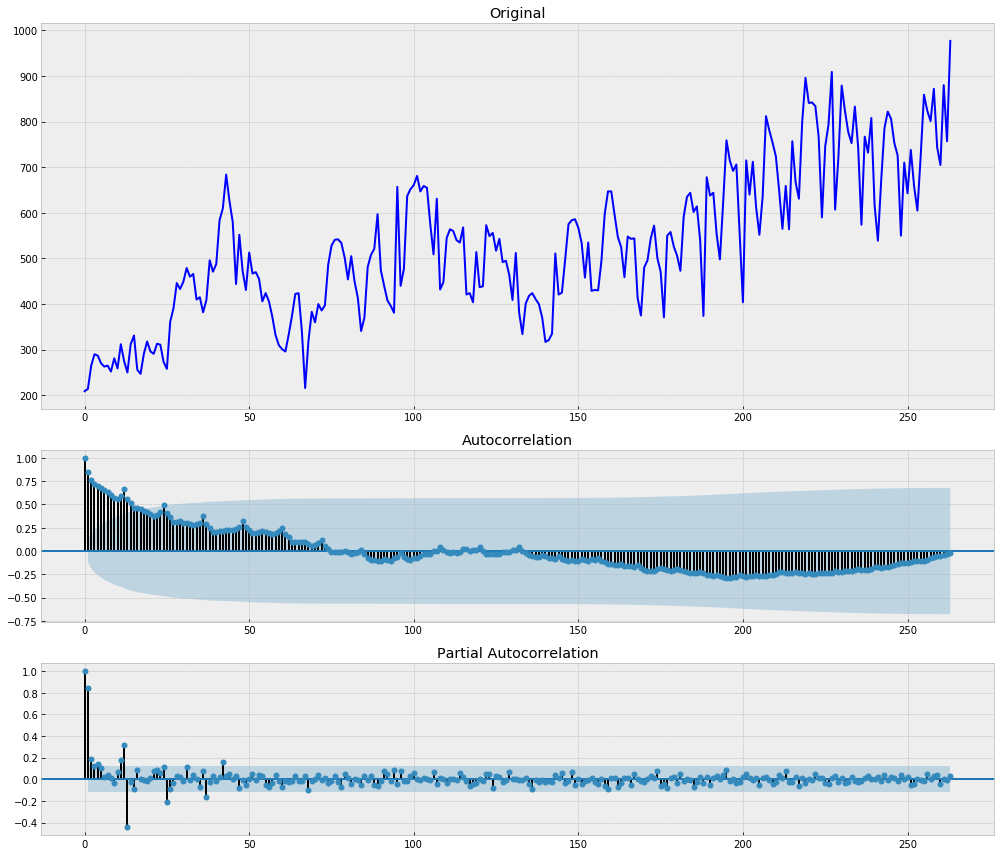

In [66]:
tsplot(registration_raw, lags=time_lags)

Тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда.

При взгляде на графики можно видеть некоторую разницу в размахе дисперсии в начале и конце временного ряда. 
    
       
По этому первым действием используем преобразование Бокса-Кокса.
       

### С использованием преобразованием Бокса-Кокса

In [117]:
registration_bc = boxcox(registration_raw, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


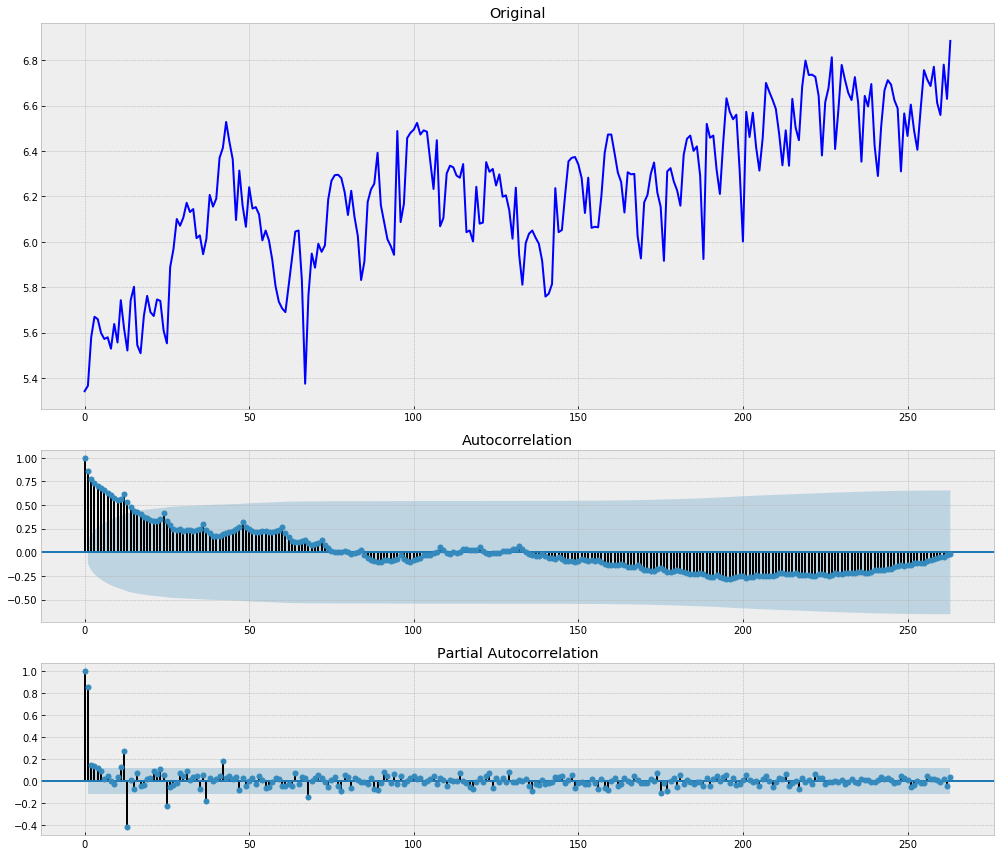

In [118]:
tsplot(registration_bc, lags=time_lags)

Как видно преобразование не достаточно сравняло размах дисперсии и тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие тренда. Уберем его дифференцированием.

In [119]:
registration_bc_d = registration_bc[1:] - registration_bc[:-1]


Results of Dickey-Fuller Test:
Test Statistic                  -4.362471
p-value                          0.000346
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


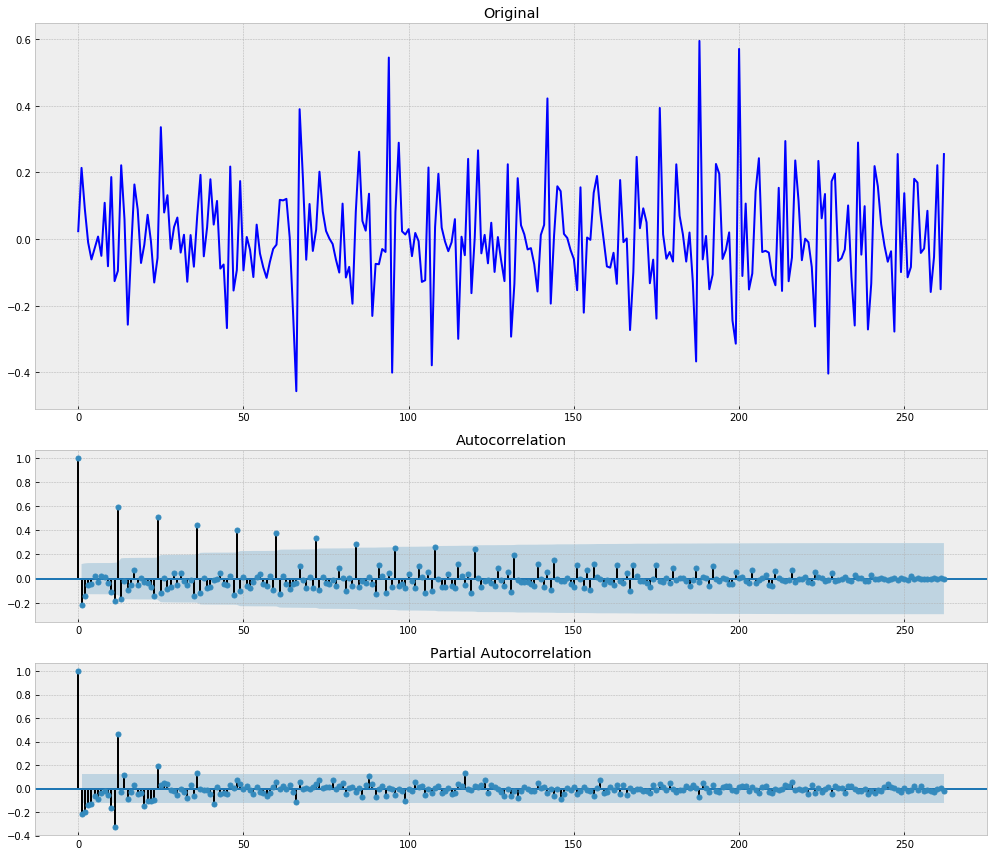

In [120]:
tsplot(registration_bc_d, lags=time_lags[:-1])

Как видно диференцирование позволило убрать тренд и тест Дикки-Фуллера позволяет отвергнуть гипотиезу о нестационарности ряда, однако по графику коррелограммы видно сильное влияние сезонности. Необходимое ее убрать.

In [121]:
registration_bc_d_s = registration_bc_d[12:] - registration_bc_d[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


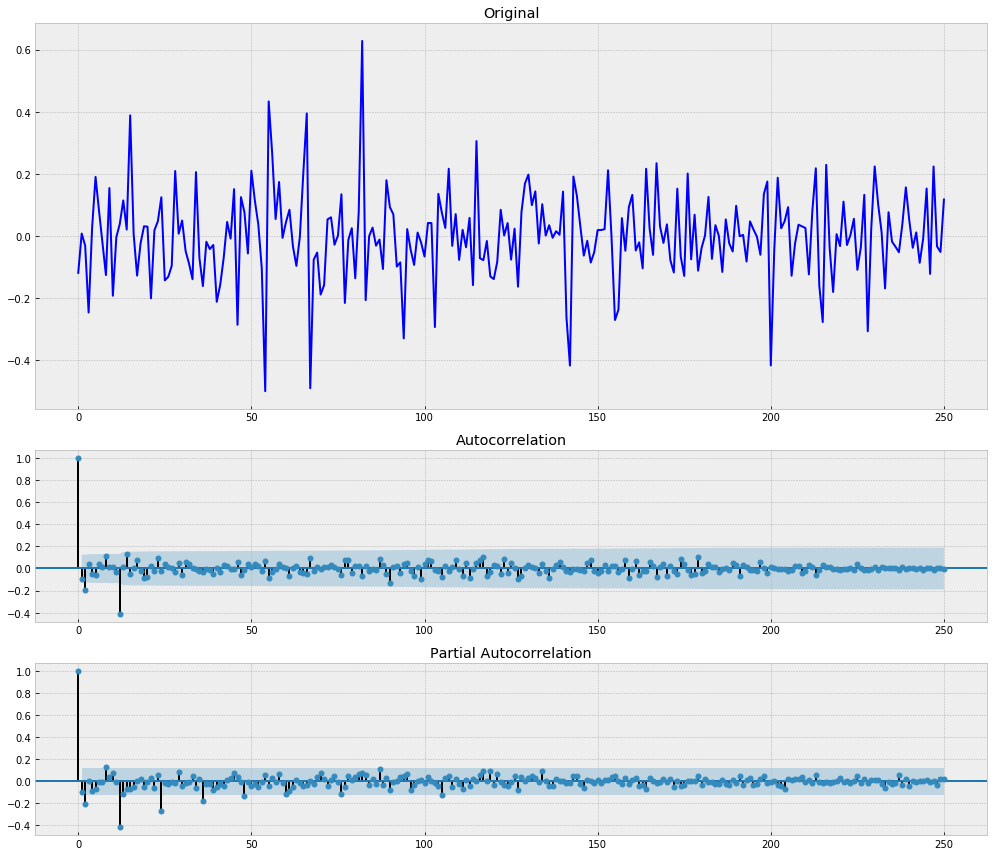

In [123]:
tsplot(registration_bc_d_s, lags=time_lags[:-13])

Теперь тест Дики-Фуллера и графики коррелограмм позволяют отвергнуть гипотезу о нестационарности ряда.

С учетом того что преобразование Бокса-Кокса не позволило убрать разницу в размехе Диспесии, 
можно попробовать привести ряд к стационарному без использования преобразования. 

### Без использования преобразования Бокса-Кокса

In [ ]:
Для уборки тренда используем дифферицирование. 

In [154]:
registration_d = registration_raw[1:] - registration_raw[:-1]

registration_d = np.diff(registration_raw, 1)


Results of Dickey-Fuller Test:
Test Statistic                  -4.176442
p-value                          0.000722
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


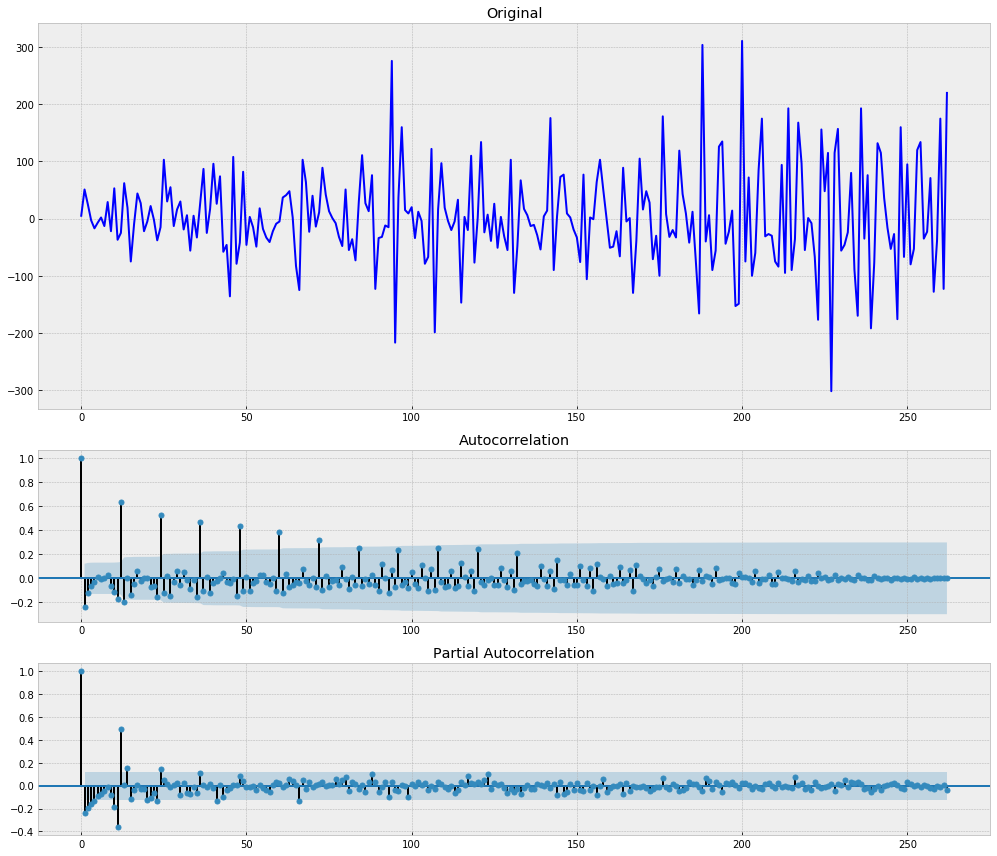

In [155]:
tsplot(registration_d)

Диференцирование позволило убрать тренд и тест Дикки-Фуллера позволяет отвергнуть гипотиезу о нестационарности ряда, однако по графику коррелограммы также видно наличие сильной сезонности. Уберем её.

In [151]:
registration_d_s = registration_d[12:] - registration_d[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.531039e+00
p-value                        9.868596e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


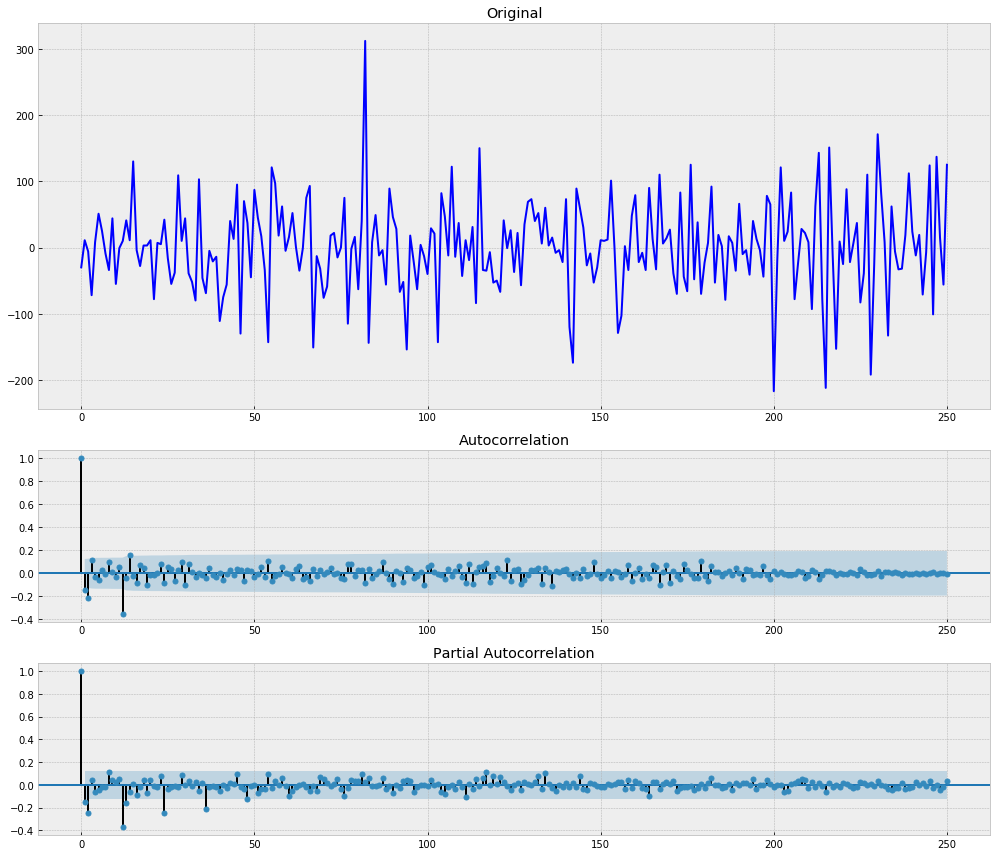

In [153]:
tsplot(registration_d_s)

Теперь тест Дики-Фуллера и графики коррелограмм также позволяют отвергнуть гипотезу о нестационарности ряда.

## Разбор ряда monthly_us_auto_registration_tho

In [160]:
dowjones.head()

,Week,DowJones
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


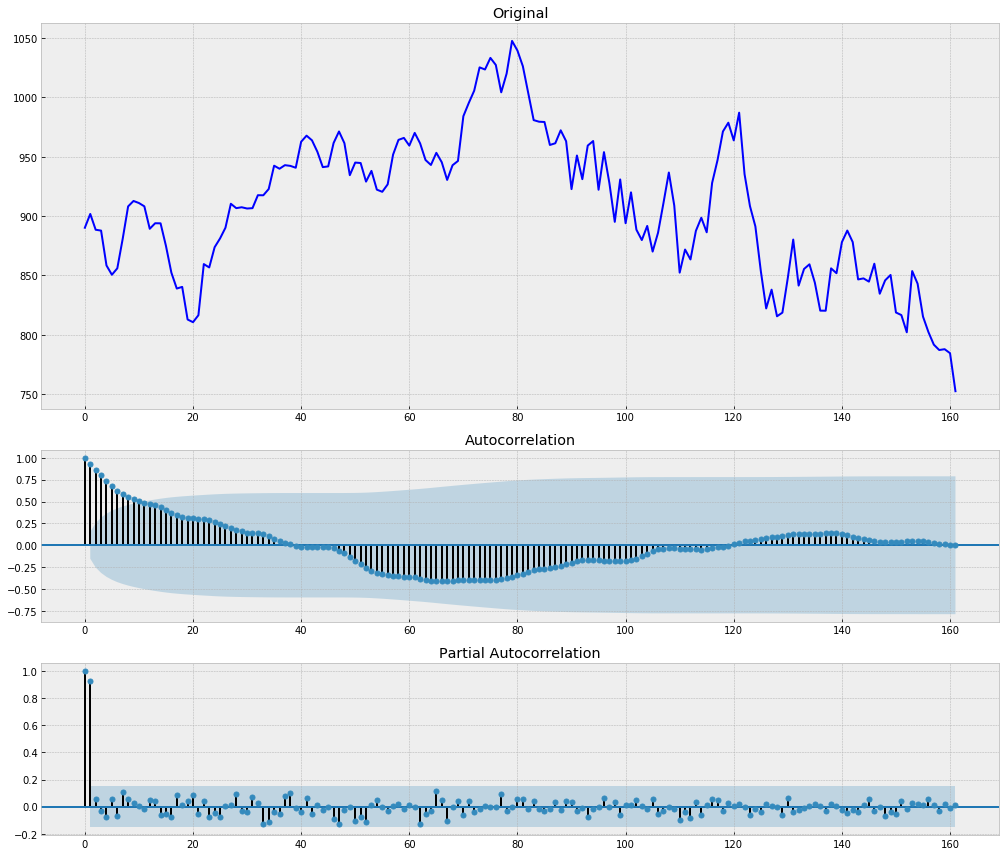

In [164]:
dowjones_raw = dowjones['DowJones']

tsplot(dowjones_raw)

Тест Дики-Фуллера, графики и коррелограммы не позволяет отвергнуть гипотезу о нестационарности ряда, 

На графике имеется тренд, причем тренд меняется примерно на середине ряда

In [168]:
dowjones_d = np.diff(dowjones_raw, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


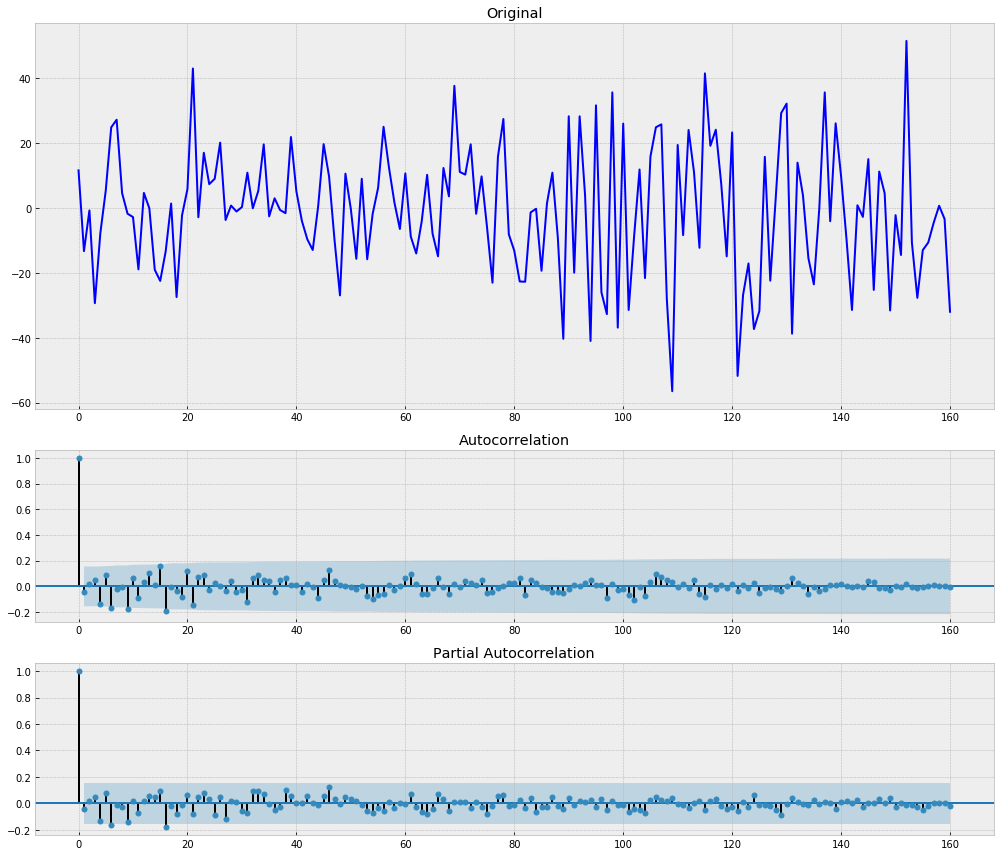

In [169]:
tsplot(dowjones_d)

Теперь тест Дики-Фуллера и графики коррелограмм также позволяют отвергнуть гипотезу о нестационарности ряда.

Однако на графике видна разница между размахом дисперсии, попробуем ее убрать преобразованием Бокса-Кокса. Граница пмежду изменением дисперсии проходит примерно тамже, где проходит смена тренда на базовом графике. 

In [202]:
dowjones_d_bc = boxcox(dowjones_d+100,0)

Results of Dickey-Fuller Test:
Test Statistic                -1.288530e+01
p-value                        4.567513e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


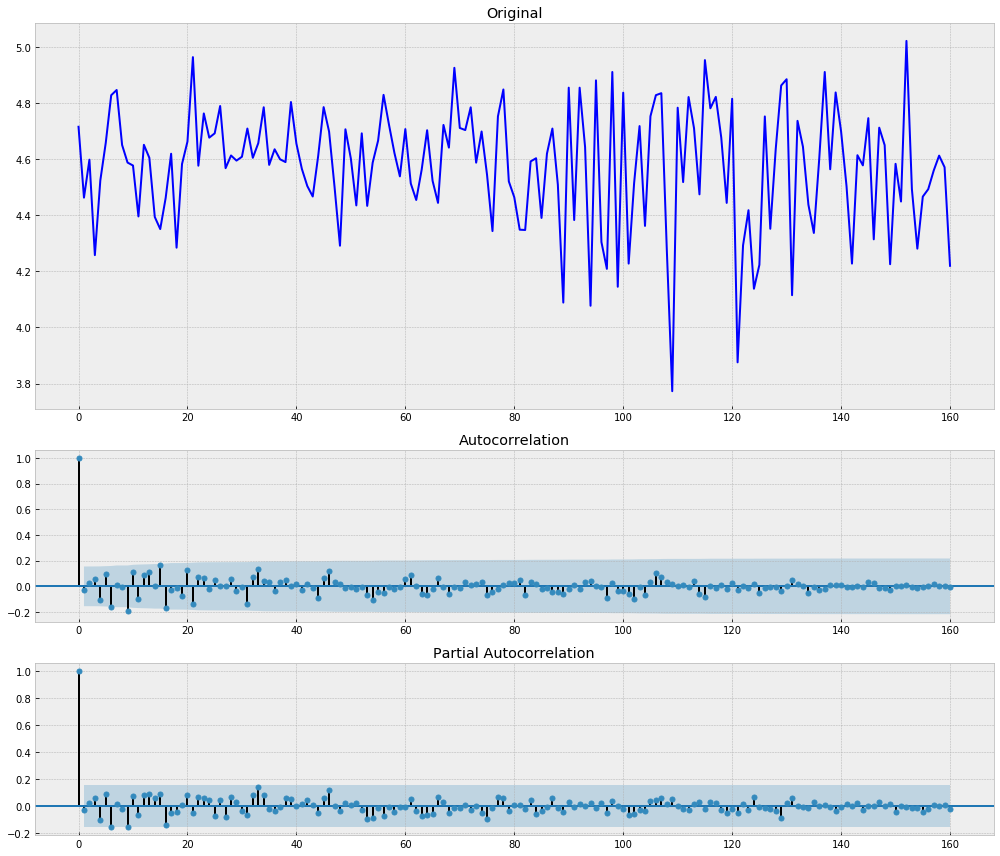

In [203]:
tsplot(dowjones_d_bc)

Использование преобразования Бокса Кокса не позволило выровнить дисперсию и немного ухудшило p-value, однако 
и тест Дики-Фуллера, и графики коррелограмм позволяют отвергнуть гипотезу о нестационарности ряда

Так как ряд меняет свое поведение, то хорошо его разбить на две части и проанализировать отдельно

In [205]:
# разделим ряд по границе пика который примерно находиться на 79 значении
dowjones_raw_1 = dowjones_raw[:80]
dowjones_raw_2 = dowjones_raw[80:]

Проанализируем вторую половину ряда, так как первыая не актуальна.

Results of Dickey-Fuller Test:
Test Statistic                 -1.954633
p-value                         0.306812
#Lags Used                      0.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


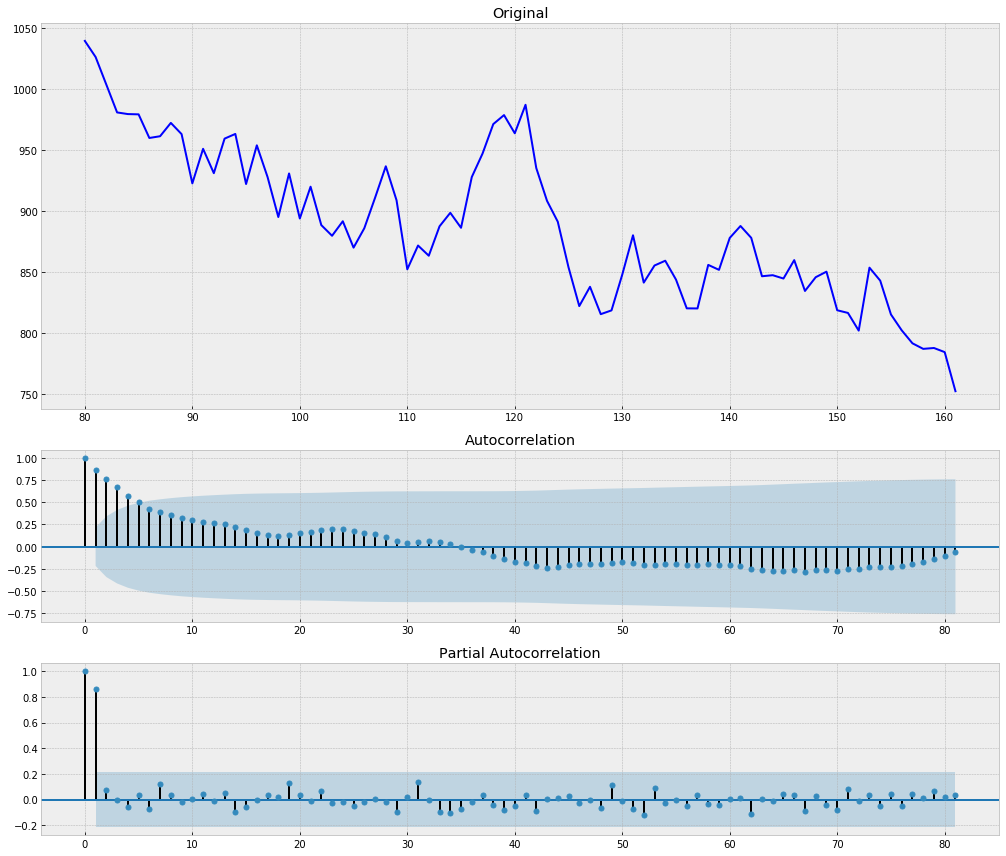

In [207]:
tsplot(dowjones_raw_2)

Как видно и результатов теста и графиков коррелограмм гипотезу о нестационарности ряда отбросить нельзя

Для преобразования ряда к стационарному виду используем преобразование Бокса Кокса, 
а для уборки тренда используем дифференцирование 


In [219]:
dowjones_raw_2_bc = boxcox(dowjones_raw_2, -0.5)

Results of Dickey-Fuller Test:
Test Statistic                 -1.646420
p-value                         0.458908
#Lags Used                      0.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


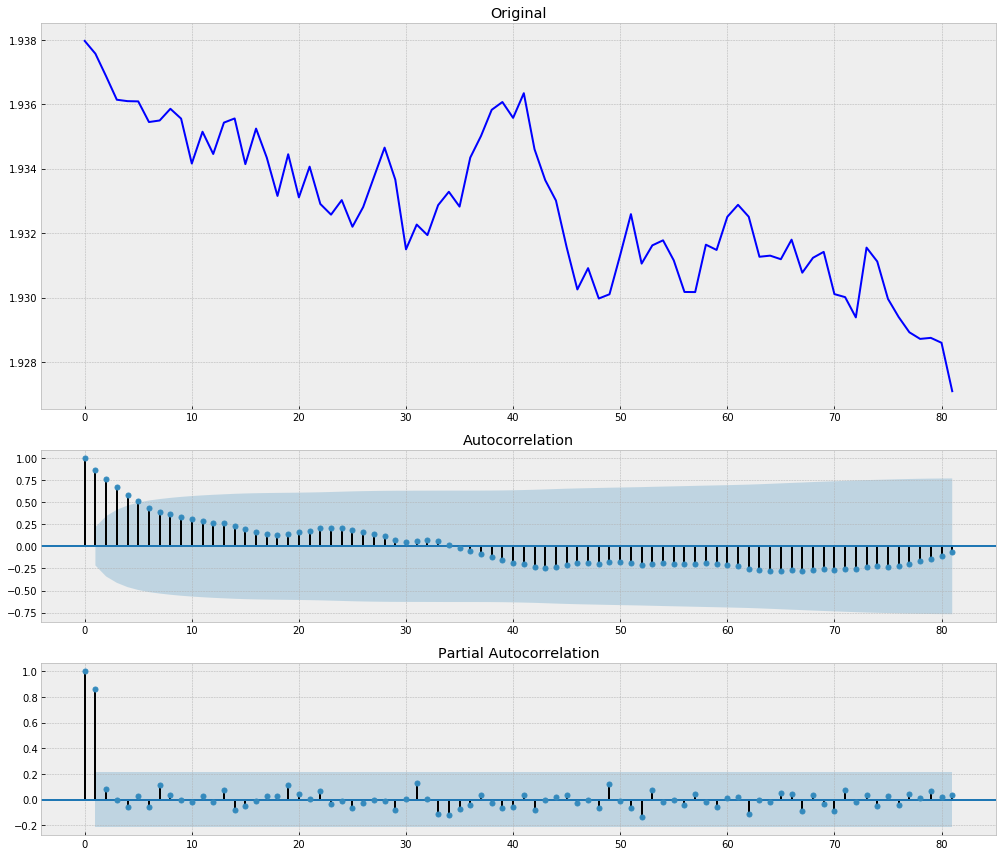

In [220]:
tsplot(dowjones_raw_2_bc)

С помощью дифференцирования уберем тренд.  

In [221]:
dowjones_raw_2_bc_d = dowjones_raw_2_bc[1:] -  dowjones_raw_2_bc[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.008471e+01
p-value                        1.163577e-17
#Lags Used                     0.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64


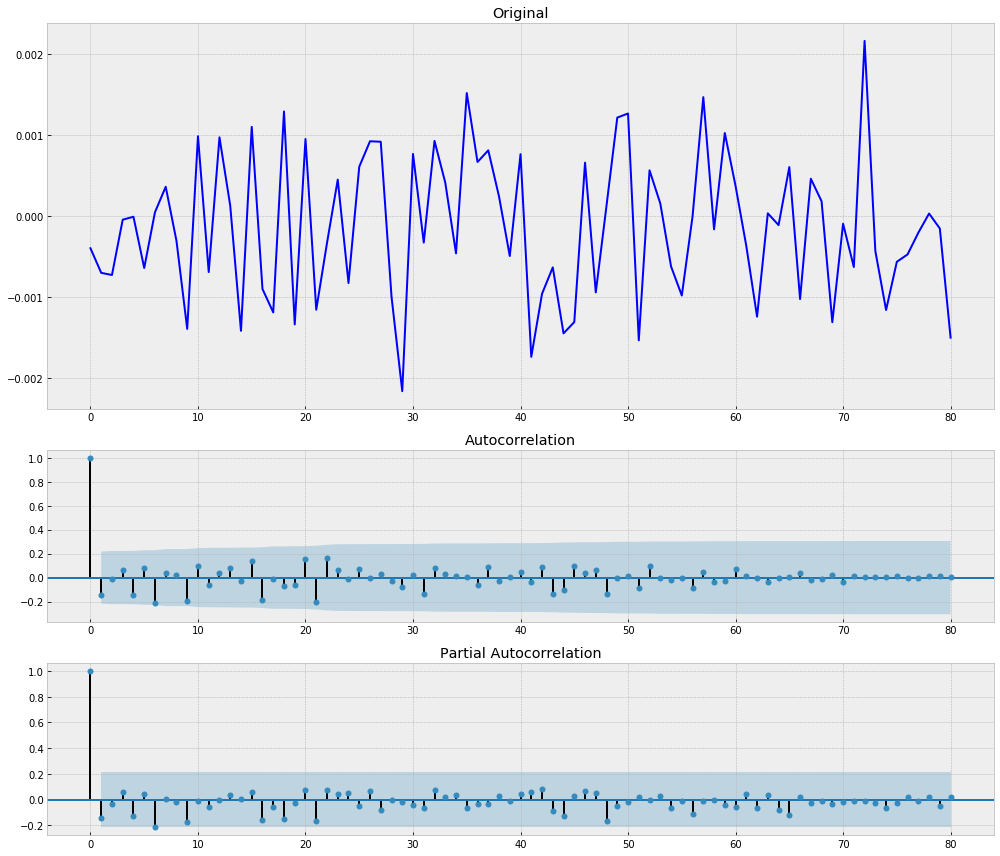

In [222]:
tsplot(dowjones_raw_2_bc_d)

Как видно из теста Дики-Фуллера и графиков коррелограмм позволяют отвергнуть гипотезу о нестационарности ряда.